In [322]:
import pandas as pd
import numpy as np
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from nltk.tokenize import word_tokenize



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [323]:
df = pd.read_csv("/Users/macbookpro/Desktop/toxic comments/labeled.csv", sep = ',')
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [324]:
#import nltk
#nltk.download()

In [325]:
#from nltk.corpus import brown
#brown.words()

In [326]:
df['toxic'] = df['toxic'].apply(int)

In [327]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [328]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [329]:
train_df, test_df = train_test_split(df, test_size=500)

In [330]:
test_df.shape

(500, 2)

In [331]:
test_df['toxic'].value_counts()

0    344
1    156
Name: toxic, dtype: int64

In [332]:
train_df['toxic'].value_counts()

0    9242
1    4670
Name: toxic, dtype: int64

In [333]:
#Разбиваем слова на токены 
sentence_example = df.iloc[0]['comment']
# разбиаем текст на кокены
tokens = word_tokenize(sentence_example, language='russian') 
# убираем знаки пунктуации
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation] 
russian_stop_words = stopwords.words('russian') 
#удаляем стоп слова русские 
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words] #удаляем руские стоп слова
# приводим к нижнему регистру и удаляем окончания
snowball = SnowballStemmer(language='russian')
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]


In [334]:
print(f'исходный текст: {sentence_example}')
print('-----------')
print(f'Токены: {tokens}')
print('-----------')
print(f'Токены без пунктуации: {tokens_without_punctuation}')
print('-----------')
print(f'Токены без пунктуации и стоп слов: {tokens_without_stop_words_and_punctuation}')
print('-----------')
print(f'Токены после стемминга: {stemmed_tokens}')
print('-----------')

исходный текст: Верблюдов-то за что? Дебилы, бл...

-----------
Токены: ['Верблюдов-то', 'за', 'что', '?', 'Дебилы', ',', 'бл', '...']
-----------
Токены без пунктуации: ['Верблюдов-то', 'за', 'что', 'Дебилы', 'бл', '...']
-----------
Токены без пунктуации и стоп слов: ['Верблюдов-то', 'Дебилы', 'бл', '...']
-----------
Токены после стемминга: ['верблюдов-т', 'дебил', 'бл', '...']
-----------


In [335]:
#Создаем функцию
snowball = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation] 
    if russian_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words] 
    tokens = [snowball.stem(i) for i in tokens]
    return tokens
        
        


In [336]:
#Проверка
tokenize_sentence(sentence_example)

['верблюдов-т', 'дебил', 'бл', '...']

In [337]:
#кодирование токенов
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [338]:
#Обучаем
features = vectorizer.fit_transform(train_df['comment'])

In [339]:
#Обучаем модель логистической регрессии
#Создаем коласс логистической регрессии
model = LogisticRegression(random_state=0)
# метод куда передаем фитчи 
model.fit(features, train_df['toxic'])

LogisticRegression(random_state=0)

In [340]:
#Проверка первого коментария
model.predict(features[0])

array([1])

In [341]:
#Текст первого коментария
train_df['comment'].iloc[0]

'Учителишки отсосут танкам Абрамс\n'

In [342]:
#Соединяем модель и фичей
model_pipeLine = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(random_state=0))
]
)

In [343]:
#Принемает список предложение
model_pipeLine.fit(train_df['comment'], train_df['toxic'])


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fb6229b6040>)),
                ('model', LogisticRegression(random_state=0))])

Проверка работоспособности модели на заданном текст: 

0 = хорошей коментарий

1 = плохой коментарий

In [344]:

model_pipeLine.predict(['Привет ребята все круто'])

array([0])

In [345]:
model_pipeLine.predict(['говнюки они все'])

array([1])

Измеряем метрики

precision

recall

In [346]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeLine.predict(test_df['comment']))

0.9074074074074074

In [347]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeLine.predict(test_df['comment']))

0.6282051282051282

Настройка метрик precision/recall

In [348]:
# находим зависимостей precision от recall
prec, rec, thresholds = precision_recall_curve(y_true=test_df['toxic'], probas_pred=model_pipeLine.predict_proba(test_df['comment'])[:,1])

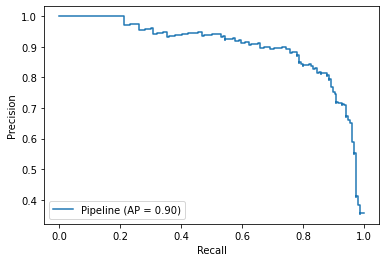

In [349]:
#рисуем график зависимостей precision от recall
plot_precision_recall_curve(estimator=model_pipeLine, X=test_df['comment'], y=test_df['toxic'])

In [350]:
#находим момент где precision > 95
np.where(prec > 0.95)

(array([387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399,
        400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412,
        413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425,
        426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437]),)

In [355]:
#порог
thresholds[432]

0.9656570387989386

In [368]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeLine.predict_proba(test_df['comment'])[:,1] > thresholds[387])

0.9591836734693877

In [369]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeLine.predict_proba(test_df['comment'])[:,1] > thresholds[387])

0.30128205128205127

precision соответствует требованиям но recall слизком низкий надо еще доработать 

При помощи GripSearch будем искать лучшую метрику

In [358]:
#Создаем новый pipeLine c gridsearch

grid_pipeLine = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', 
    GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        )
    )
])


In [359]:
# Обучаем pipeline 
grid_pipeLine.fit(train_df['comment'], train_df['toxic'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=0.1, score=0.687, total=   0.9s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ............................... C=0.1, score=0.687, total=   0.4s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] ............................... C=0.1, score=0.685, total=   0.4s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV] ................................. C=1, score=0.845, total=   0.6s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.842, total=   0.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.833, total=   0.5s
[CV] C=10.0 ..........................................................


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .............................. C=10.0, score=0.871, total=   0.9s
[CV] C=10.0 ..........................................................


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .............................. C=10.0, score=0.872, total=   1.1s
[CV] C=10.0 ..........................................................
[CV] .............................. C=10.0, score=0.865, total=   1.1s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.4s finished
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fb60ce12670>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [360]:
#Проверяем резултат cv=10
model_pipeLine_c10 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(random_state=0, C=10))
]
)

In [361]:
# Обучаем
model_pipeLine_c10.fit(train_df['comment'], train_df['toxic'])

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fb60f682430>)),
                ('model', LogisticRegression(C=10, random_state=0))])

In [364]:
# находим зависимостей precision от recall
prec_с10, rec_с10, thresholds_с10 = precision_recall_curve(y_true=test_df['toxic'], probas_pred=model_pipeLine_c10.predict_proba(test_df['comment'])[:,1])

In [365]:
np.where(prec_с10 > 0.95)

(array([376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
        389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401,
        402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
        415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427,
        428, 429]),)

In [366]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeLine_c10.predict_proba(test_df['comment'])[:,1] > thresholds_с10[376])

0.9615384615384616

In [367]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeLine_c10.predict_proba(test_df['comment'])[:,1] > thresholds_с10[376])

0.32051282051282054

Результат: Модель умеет разделять плохие коментария от хороших. 

Модель обучена и настроина

precision соответствует требованиям > 95 

recall улучшели показатели 

In [377]:
model_pipeLine_c10.predict(['Привет ребята все круто'])


array([0])

In [378]:
model_pipeLine_c10.predict(['Привет козлы все круто'])

array([1])